# Problem Definition 

## In Cologne the rents are very high and it is difficult to know if the rent is reasonable or too high when looking for an apartment. 
## So with this Project we can help people to see:
1. If the rent demanded by the owner is too high for the spesific District
2. Which district is the cheapest district 
3. which area is the best regarding the venues

## This project helps people who want to move to Cologne or people who already live in Cologne but are looking for a new apartment.  

## Data: 
### The data on apartments (size, number of rooms, address, and price) is collected by scraping a local website with apartment listings (Immoscout24.de). For the coordinates of the districts we use geopy and take the Data from the official Geodata site of the city cologne (offenedaten-koeln.de) . To Collect the Venues I use Foursquare. After the Data collection process we run k-means clustering to cluster the districts into residential and commercial areas and visualize the data on a choropleth map. 

In [1]:
conda install -c anaconda beautifulsoup4

SyntaxError: invalid syntax (<ipython-input-1-0133b164eb34>, line 1)

# crawl Immoscout24.de to find the offert apartments in the web

### Import libraries 

In [2]:
from bs4 import BeautifulSoup
import json
import urllib.request as urllib2
import random
from random import choice
import time

### function cycles randomly through different user agents and time intervals to simulate more natural queries

In [3]:
def urlquery(url):
    
    try:
        sleeptime = float(random.randint(1,6))/5
        time.sleep(sleeptime)

        agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17',
        'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0',
        'Opera/12.80 (Windows NT 5.1; U; en) Presto/2.10.289 Version/12.02',
        'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)',
        'Mozilla/3.0',
        'Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420+ (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3',
        'Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522+ (KHTML, like Gecko) Safari/419.3',
        'Opera/9.00 (Windows NT 5.1; U; en)']

        agent = choice(agents)
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', agent)]

        html = opener.open(url).read()
        time.sleep(sleeptime)
        
        return html

    except Exception as e:
        print('Something went wrong with Crawling:\n%s' % e)

### Parser to get the informations through beautifulSoup 

In [4]:
def immoscout24parser(url):
    
    ''' Parser holt aus Immoscout24.de Suchergebnisseiten die Immobilien '''
    
    try:
        soup = BeautifulSoup(urlquery(url), 'html.parser')
        scripts = soup.findAll('script')
        for script in scripts:
            #print script.text.strip()
            if 'IS24.resultList' in script.text.strip():
                s = script.string.split('\n')
                for line in s:
                    #print('\n\n\'%s\'' % line)
                    if line.strip().startswith('resultListModel'):
                        resultListModel = line.strip('resultListModel: ')
                        immo_json = json.loads(resultListModel[:-1])

                        searchResponseModel = immo_json[u'searchResponseModel']
                        resultlist_json = searchResponseModel[u'resultlist.resultlist']
                        
                        return resultlist_json

    except Exception as e:
        print("Fehler in immoscout24 parser: %s" % e)

### This functions crawls every site from the search results of cologne

In [5]:
immos = {}

# See immoscout24.de URL in Browser!
b = 'Nordrhein-Westfalen' # Bundesland
s = 'Koeln' # Stadt
k = 'Wohnung' # Wohnung oder Haus
w = 'Miete' # Miete oder Kauf

page = 0
print('Suche %s / %s' % (k, w))

while True:
    page+=1
    url = 'http://www.immobilienscout24.de/Suche/S-T/P-%s/%s-%s/%s/%s?pagerReporting=true' % (page, k, w, b, s)

    # Because of some timeout or immoscout24.de errors,
    # we try until it works \o/
    resultlist_json = None
    while resultlist_json is None:
        try:
            resultlist_json = immoscout24parser(url)
            numberOfPages = int(resultlist_json[u'paging'][u'numberOfPages'])
            pageNumber = int(resultlist_json[u'paging'][u'pageNumber'])
        except:
            pass

    if page>numberOfPages:
        break

    # Get the data
    for resultlistEntry in resultlist_json['resultlistEntries'][0][u'resultlistEntry']:
        realEstate_json = resultlistEntry[u'resultlist.realEstate']
        
        realEstate = {}

        realEstate[u'Miete/Kauf'] = w
        realEstate[u'Haus/Wohnung'] = k

        realEstate['address'] = realEstate_json['address']['description']['text']
        realEstate['city'] = realEstate_json['address']['city']
        realEstate['postcode'] = realEstate_json['address']['postcode']
        realEstate['quarter'] = realEstate_json['address']['quarter']
        try:
            realEstate['lat'] = realEstate_json['address'][u'wgs84Coordinate']['latitude']
            realEstate['lon'] = realEstate_json['address'][u'wgs84Coordinate']['longitude']
        except:
            realEstate['lat'] = None
            realEstate['lon'] = None
            
        realEstate['title'] = realEstate_json['title']

        realEstate['numberOfRooms'] = realEstate_json['numberOfRooms']
        realEstate['livingSpace'] = realEstate_json['livingSpace']
        
        if k=='Wohnung':
            realEstate['balcony'] = realEstate_json['balcony']
            realEstate['builtInKitchen'] = realEstate_json['builtInKitchen']
            realEstate['garden'] = realEstate_json['garden']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
        elif k=='Haus':
            realEstate['isBarrierFree'] = realEstate_json['isBarrierFree']
            realEstate['cellar'] = realEstate_json['cellar']
            realEstate['plotArea'] = realEstate_json['plotArea']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
            realEstate['energyPerformanceCertificate'] = realEstate_json['energyPerformanceCertificate']
        
        realEstate['floorplan'] = realEstate_json['floorplan']
        realEstate['from'] = realEstate_json['companyWideCustomerId']
        realEstate['ID'] = realEstate_json[u'@id']
        realEstate['url'] = u'https://www.immobilienscout24.de/expose/%s' % realEstate['ID']

        immos[realEstate['ID']] = realEstate
        
    print('Scrape Page %i/%i (%i Immobilien %s %s gefunden)' % (page, numberOfPages, len(immos), k, w))

Suche Wohnung / Miete
Scrape Page 1/49 (20 Immobilien Wohnung Miete gefunden)
Scrape Page 2/49 (40 Immobilien Wohnung Miete gefunden)
Scrape Page 3/49 (60 Immobilien Wohnung Miete gefunden)
Scrape Page 4/49 (80 Immobilien Wohnung Miete gefunden)
Scrape Page 5/49 (100 Immobilien Wohnung Miete gefunden)
Scrape Page 6/49 (120 Immobilien Wohnung Miete gefunden)
Scrape Page 7/49 (140 Immobilien Wohnung Miete gefunden)
Scrape Page 8/49 (160 Immobilien Wohnung Miete gefunden)
Scrape Page 9/49 (180 Immobilien Wohnung Miete gefunden)
Scrape Page 10/49 (200 Immobilien Wohnung Miete gefunden)
Scrape Page 11/49 (220 Immobilien Wohnung Miete gefunden)
Scrape Page 12/49 (240 Immobilien Wohnung Miete gefunden)
Scrape Page 13/49 (260 Immobilien Wohnung Miete gefunden)
Scrape Page 14/49 (280 Immobilien Wohnung Miete gefunden)
Scrape Page 15/49 (300 Immobilien Wohnung Miete gefunden)
Scrape Page 16/49 (320 Immobilien Wohnung Miete gefunden)
Scrape Page 17/49 (340 Immobilien Wohnung Miete gefunden)
Scrap

In [6]:
print("Scraped %i Immos" % len(immos))

Scraped 970 Immos


### Put results in dataframe

In [7]:
from datetime import datetime
timestamp = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(immos).T
df.index.name = 'ID'

In [10]:
df.livingSpace[df.livingSpace==0] = None
df['EUR/qm'] = df.price / df.livingSpace

In [11]:
df.sort_values(by='EUR/qm', inplace=True)

In [12]:
len(df)

970

In [13]:
df.head()

Haus/Wohnung         ID Miete/Kauf  \
ID                                             
117826677      Wohnung  117826677      Miete   
47462593       Wohnung   47462593      Miete   
97006573       Wohnung   97006573      Miete   
117096394      Wohnung  117096394      Miete   
83540344       Wohnung   83540344      Miete   

                                                 address balcony  \
ID                                                                 
117826677                  Braunfelsweg 1, Seeberg, Köln    true   
47462593                 Im Falkenhorst 12, Urbach, Köln    true   
97006573           Trenkebergerstr. 15, Meschenich, Köln   false   
117096394          Trenkebergerstr. 15, Meschenich, Köln   false   
83540344   Alte Fischenicher Straße 31, Meschenich, Köln    true   

          builtInKitchen  city floorplan         from garden  ... livingSpace  \
ID                                                            ...               
117826677          false  Köln     false   001.685264  false  ...          53   
47462593           false  Köln      true  001.3187698  false  ...       73.66   
97006573           false  Köln     false   001.528711  false  ...       27.52   
117096394          false  Köln     false   001.528711  false  ...       42.86   
83540344           false  Köln     false   001.473881   true  ...          75   

               lon numberOfRooms postcode   price privateOffer     quarter  \
ID                                                                           
117826677  6.90357             2    50769  329.16        false     Seeberg   
47462593   7.08184             3    51145  494.25         true      Urbach   
97006573   6.92922             1    50997  198.14        false  Meschenich   
117096394  6.92922             2    50997  308.59        false  Meschenich   
83540344   6.92389             3    50997     560        false  Meschenich   

                                                       title  \
ID                                                             
117826677  2-Zimmer-Wohnung mit Balkon für Mieter ab 60 J...   
47462593                     Schöne 3-Zi.Whg. in Porz-Urbach   
97006573   Schöne 1-Zimmer-Dachgeschosswohnung in Köln-Me...   
117096394         Schöne 2-Zimmer-Wohnung in Köln-Meschenich   
83540344   ***Köln-Meschenich- 3 Zimmerwohnung mit Balkon...   

                                                         url   EUR/qm  
ID                                                                     
117826677  https://www.immobilienscout24.de/expose/117826677  6.21057  
47462593    https://www.immobilienscout24.de/expose/47462593  6.70988  
97006573    https://www.immobilienscout24.de/expose/97006573  7.19985  
117096394  https://www.immobilienscout24.de/expose/117096394  7.19995  
83540344    https://www.immobilienscout24.de/expose/83540344  7.46667  

[5 rows x 21 columns]

In [14]:
f = open('%s-%s-%s-%s-%s.csv' % (timestamp, b, s, k, w), 'w')
f.write('# %s %s from immoscout24.de on %s\n' % (k,w,timestamp))
df[(df['Haus/Wohnung']==k) & (df['Miete/Kauf']==w)].to_csv(f, encoding='utf-8')
f.close()

In [15]:
df.to_excel('%s-%s-%s-%s-%s.xlsx' % (timestamp, b, s, k, w))

In [16]:
df = df.drop(['ID', 'Haus/Wohnung', 'Miete/Kauf', 'balcony', 'builtInKitchen', 'floorplan', 'from', 'garden', 'title', 'url', 'lat'], axis=1)

df.head()

In [17]:
df = df.reset_index()

In [18]:
df = df.drop(['ID', 'lon'], axis= 1)

In [19]:
df = df.drop(['privateOffer', 'city', 'address'], axis= 1)

In [20]:
df = df.rename(columns={"livingSpace":"Size", "numberOfRooms": "Rooms", "postcode": "PostalCode", "price": "Price", "quarter": "District", "EUR/qm": "Price/m2"})

In [21]:
df = df[['PostalCode', 'District', 'Size', 'Rooms', 'Price', 'Price/m2']]

In [22]:
df.head()

PostalCode    District   Size Rooms   Price Price/m2
0      50769     Seeberg     53     2  329.16  6.21057
1      51145      Urbach  73.66     3  494.25  6.70988
2      50997  Meschenich  27.52     1  198.14  7.19985
3      50997  Meschenich  42.86     2  308.59  7.19995
4      50997  Meschenich     75     3     560  7.46667

### Import other libraries

In [23]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

## Pre-process & visualization the data

### Adjust the data so they have the same format for each column

In [24]:
rental_properties = df[['PostalCode', 'District', 'Size', 'Rooms', 'Price', 'Price/m2']]

In [25]:
rental_properties.dtypes

PostalCode    object
District      object
Size          object
Rooms         object
Price         object
Price/m2      object
dtype: object

In [26]:
rental_properties['Price'] = rental_properties['Price'].astype('float')
rental_properties['Price/m2'] = rental_properties['Price/m2'].astype('float')
rental_properties['Size'] = rental_properties['Size'].astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')

In [27]:
rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
Price/m2      float64
dtype: object

### Checking if there are any NAN values

In [28]:
rental_properties.isnull().sum().sum()

4

### Let's check how many apartments per room number we have in our dataset

In [29]:
rental_properties['Rooms'].value_counts()

2.0    307
1.0    261
3.0    250
4.0     79
2.5     21
5.0     19
1.5     16
3.5     11
6.0      3
4.5      2
7.0      1
Name: Rooms, dtype: int64

### Let's remove all rows with rooms larger than 6. Apartments bigger than 6 will most likely be luxurious apartments and does not fit the target group.

In [30]:
rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

### We can visualize the number of apartments per room number and number of apartments in each district

[Text(0, 0, '50667'),
 Text(0, 0, '50668'),
 Text(0, 0, '50670'),
 Text(0, 0, '50672'),
 Text(0, 0, '50674'),
 Text(0, 0, '50676'),
 Text(0, 0, '50677'),
 Text(0, 0, '50678'),
 Text(0, 0, '50679'),
 Text(0, 0, '50696'),
 Text(0, 0, '50698'),
 Text(0, 0, '50733'),
 Text(0, 0, '50735'),
 Text(0, 0, '50737'),
 Text(0, 0, '50739'),
 Text(0, 0, '50765'),
 Text(0, 0, '50767'),
 Text(0, 0, '50769'),
 Text(0, 0, '50823'),
 Text(0, 0, '50825'),
 Text(0, 0, '50827'),
 Text(0, 0, '50829'),
 Text(0, 0, '50858'),
 Text(0, 0, '50859'),
 Text(0, 0, '50931'),
 Text(0, 0, '50933'),
 Text(0, 0, '50935'),
 Text(0, 0, '50937'),
 Text(0, 0, '50939'),
 Text(0, 0, '50968'),
 Text(0, 0, '50969'),
 Text(0, 0, '50996'),
 Text(0, 0, '50997'),
 Text(0, 0, '50999'),
 Text(0, 0, '51061'),
 Text(0, 0, '51063'),
 Text(0, 0, '51065'),
 Text(0, 0, '51067'),
 Text(0, 0, '51069'),
 Text(0, 0, '51103'),
 Text(0, 0, '51105'),
 Text(0, 0, '51107'),
 Text(0, 0, '51109'),
 Text(0, 0, '51113'),
 Text(0, 0, '51143'),
 Text(0, 0

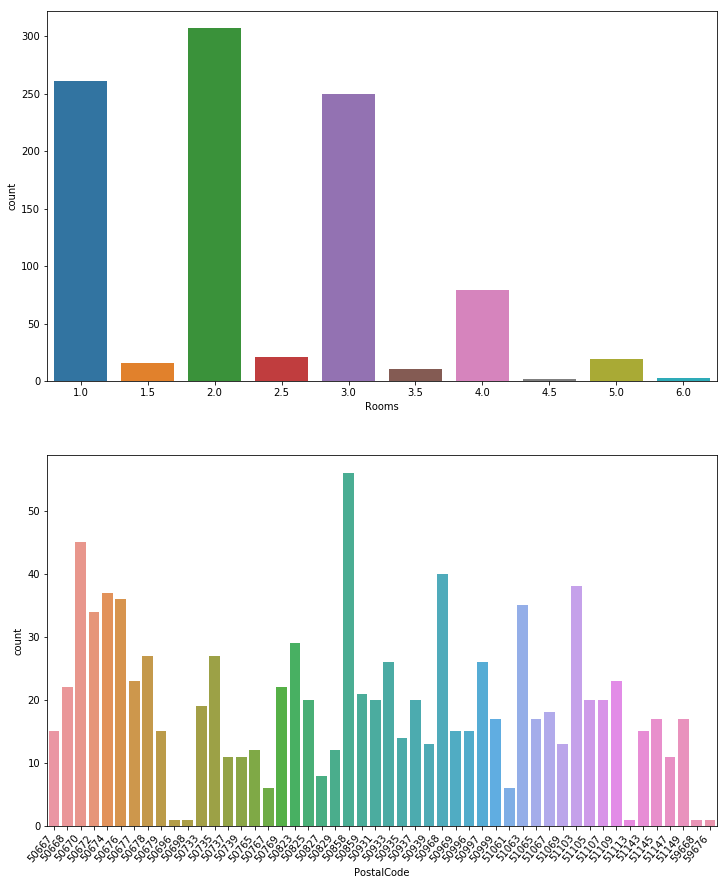

In [31]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['PostalCode'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

### Plot Price to check for Outliers

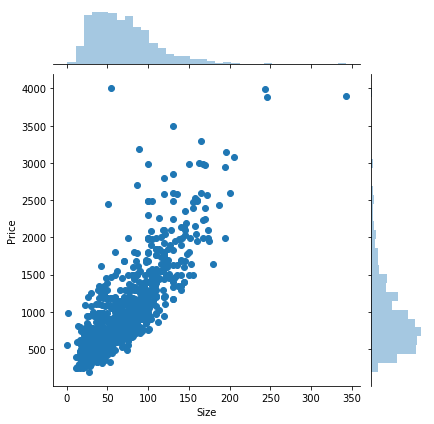

In [32]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

### Remove Outliers

In [33]:
rental_properties = rental_properties[rental_properties['Price'] <= 3600]

In [34]:
rental_properties = rental_properties[rental_properties['Price/m2'] <= 400 ]

In [35]:
rental_properties.to_excel("output.xlsx",
             sheet_name='Sheet_name_1') 

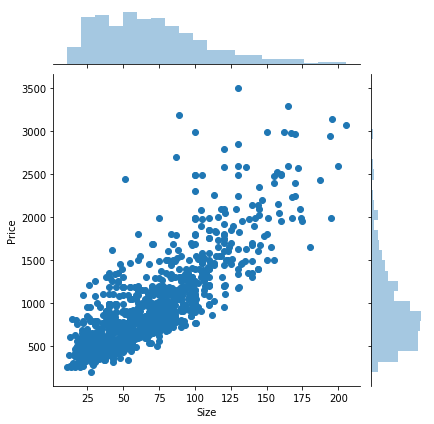

In [36]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

### Remove Appartments with an price/m2 over EUR 40,-- because these are mostely appartments with furniture.

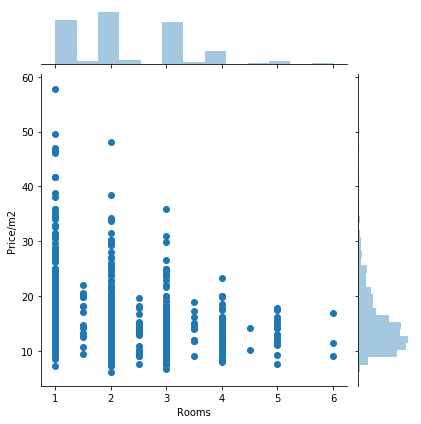

In [37]:
sns.jointplot(x='Rooms', y='Price/m2', data=rental_properties[['Rooms','Price/m2']])

In [38]:
rental_properties = rental_properties[rental_properties['Price/m2'] <= 40 ]

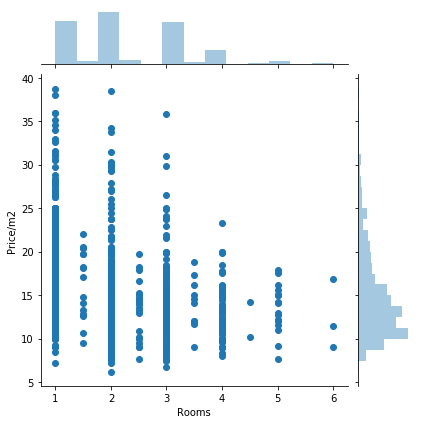

In [39]:
sns.jointplot(x='Rooms', y='Price/m2', data=rental_properties[['Rooms','Price/m2']])

### The prices are increasing as the number of rooms is increasing. Interesting to see in this Plot is that the price for 6 room apartments are decreasing.

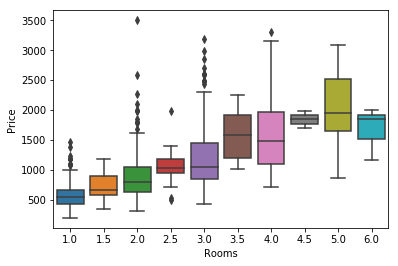

In [40]:
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

### In this Plot we can see that the Prices for all Rooms are approx. in the same range except the 1 and 1.5 room apartments.

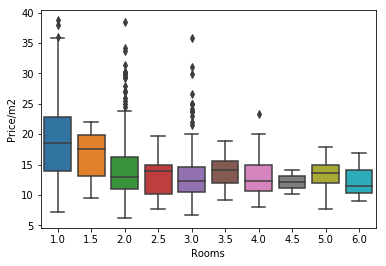

In [41]:
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

### Let's also check the difference in price/m2 in ech district.

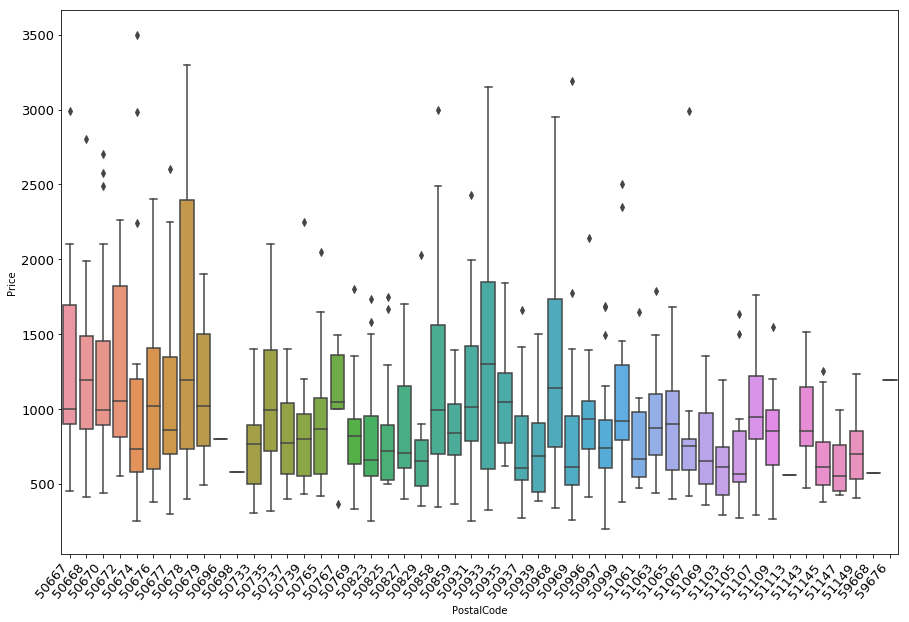

In [42]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

## Get coordinates for each district

In [43]:
cologne_districts = rental_properties[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)

In [44]:
cologne_districts

PostalCode                  District
0        50667  Altstadt & Neustadt-Nord
1        50668  Altstadt & Neustadt-Nord
2        50670   Altstadt & Neustadt-Süd
3        50670  Altstadt & Neustadt-Nord
4        50672   Altstadt & Neustadt-Süd
5        50672                 Ehrenfeld
6        50672  Altstadt & Neustadt-Nord
7        50674   Altstadt & Neustadt-Süd
8        50674  Altstadt & Neustadt-Nord
9        50676  Altstadt & Neustadt-Nord
10       50676   Altstadt & Neustadt-Süd
11       50677  Altstadt & Neustadt-Nord
12       50677   Altstadt & Neustadt-Süd
13       50678   Altstadt & Neustadt-Süd
14       50679                     Deutz
15       50696                 Zollstock
16       50698                 Raderthal
17       50733                    Nippes
18       50735                     Niehl
19       50735               Weidenpesch
20       50735                     Riehl
21       50737               Weidenpesch
22       50737                 Longerich
23       50739               Weidenpesch
24       50739           Bilderstöckchen
25       50739                 Mauenheim
26       50739                 Longerich
27       50765                Blumenberg
28       50765          Volkhoven/Weiler
29       50765             Esch/Auweiler
..         ...                       ...
91       51103                      Kalk
92       51103                   Merheim
93       51103                 Höhenberg
94       51103                    Vingst
95       51105                      Kalk
96       51105         Humboldt/Gremberg
97       51105                      Poll
98       51107                   Ostheim
99       51107               Rath/Heumar
100      51109                   Merheim
101      51109                     Brück
102      51109                  Neubrück
103      51109                   Ostheim
104      51113                      Kalk
105      51143                    Langel
106      51143                   Zündorf
107      51143                      Porz
108      51145                       Eil
109      51145                      Porz
110      51145                    Urbach
111      51147                   Grengel
112      51147                      Lind
113      51147                 Wahnheide
114      51147                      Wahn
115      51149                Finkenberg
116      51149                 Westhoven
117      51149             Gremberghoven
118      51149                     Ensen
119      59668  Altstadt & Neustadt-Nord
120      59676   Altstadt & Neustadt-Süd

[121 rows x 2 columns]

### Import other libraries

In [45]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

### Make list with Disctricts

In [46]:
cologne_districts['District'] = cologne_districts['District'].replace(['Altstadt & Neustadt-Nord'], 'Altstadt')
cologne_districts['District'] = cologne_districts['District'].replace(['Altstadt & Neustadt-Süd'], 'Altstadt')

In [49]:
cologne_districts['District']

0               Altstadt
1               Altstadt
2               Altstadt
3               Altstadt
4               Altstadt
5              Ehrenfeld
6               Altstadt
7               Altstadt
8               Altstadt
9               Altstadt
10              Altstadt
11              Altstadt
12              Altstadt
13              Altstadt
14                 Deutz
15             Zollstock
16             Raderthal
17                Nippes
18                 Niehl
19           Weidenpesch
20                 Riehl
21           Weidenpesch
22             Longerich
23           Weidenpesch
24       Bilderstöckchen
25             Mauenheim
26             Longerich
27            Blumenberg
28      Volkhoven/Weiler
29         Esch/Auweiler
             ...        
91                  Kalk
92               Merheim
93             Höhenberg
94                Vingst
95                  Kalk
96     Humboldt/Gremberg
97                  Poll
98               Ostheim
99           Rath/Heumar


### Get coordinates through Geopy Nominatim. 

In [50]:
from geopy.extra.rate_limiter import RateLimiter
latitude = np.zeros(cologne_districts.shape[0])
longitude = np.zeros(cologne_districts.shape[0])

geolocator = Nominatim(user_agent="cologne_district")

for idx in range(cologne_districts.shape[0]):
    address = cologne_districts['District'].loc[idx] + ', Köln'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude
    time.sleep(2)

In [51]:
district_coordinates = cologne_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

PostalCode           District   Latitude  Longitude
0        50667           Altstadt  50.938361   6.959974
1        50668           Altstadt  50.938361   6.959974
2        50670           Altstadt  50.938361   6.959974
3        50670           Altstadt  50.938361   6.959974
4        50672           Altstadt  50.938361   6.959974
5        50672          Ehrenfeld  50.967993   6.887914
6        50672           Altstadt  50.938361   6.959974
7        50674           Altstadt  50.938361   6.959974
8        50674           Altstadt  50.938361   6.959974
9        50676           Altstadt  50.938361   6.959974
10       50676           Altstadt  50.938361   6.959974
11       50677           Altstadt  50.938361   6.959974
12       50677           Altstadt  50.938361   6.959974
13       50678           Altstadt  50.938361   6.959974
14       50679              Deutz  50.936759   6.973046
15       50696          Zollstock  50.909869   6.941747
16       50698          Raderthal  50.900683   6.954855
17       50733             Nippes  50.988649   6.935727
18       50735              Niehl  50.989829   6.962707
19       50735        Weidenpesch  50.983000   6.946341
20       50735              Riehl  50.963913   6.976871
21       50737        Weidenpesch  50.983000   6.946341
22       50737          Longerich  50.997324   6.913713
23       50739        Weidenpesch  50.983000   6.946341
24       50739    Bilderstöckchen  50.968654   6.929361
25       50739          Mauenheim  50.973039   6.946731
26       50739          Longerich  50.997324   6.913713
27       50765         Blumenberg  51.036924   6.886195
28       50765   Volkhoven/Weiler  51.020118   6.876163
29       50765      Esch/Auweiler  51.007287   6.856081
..         ...                ...        ...        ...
91       51103               Kalk  50.935969   7.066925
92       51103            Merheim  50.950419   7.048598
93       51103          Höhenberg  50.941003   7.026215
94       51103             Vingst  50.932954   7.021241
95       51105               Kalk  50.935969   7.066925
96       51105  Humboldt/Gremberg  50.925604   7.007676
97       51105               Poll  50.912101   6.988889
98       51107            Ostheim  50.931393   7.045736
99       51107        Rath/Heumar  50.928474   7.099785
100      51109            Merheim  50.950419   7.048598
101      51109              Brück  50.945627   7.079518
102      51109           Neubrück  50.935389   7.058893
103      51109            Ostheim  50.931393   7.045736
104      51113               Kalk  50.935969   7.066925
105      51143             Langel  50.849068   7.011603
106      51143            Zündorf  50.865926   7.042982
107      51143               Porz  50.879923   7.095074
108      51145                Eil  50.895408   7.078521
109      51145               Porz  50.879923   7.095074
110      51145             Urbach  50.880978   7.081889
111      51147            Grengel  50.879890   7.101859
112      51147               Lind  50.848990   7.102453
113      51147          Wahnheide  50.859911   7.103522
114      51147               Wahn  50.858854   7.085497
115      51149         Finkenberg  50.896079   7.064600
116      51149          Westhoven  50.898321   7.022011
117      51149      Gremberghoven  50.904738   7.054786
118      51149              Ensen  50.897202   7.031151
119      59668           Altstadt  50.938361   6.959974
120      59676           Altstadt  50.938361   6.959974

[121 rows x 4 columns]

## Display the Districts on a Map 
### Installing Folium

In [52]:
! pip install folium

     |████████████████████████████████| 92kB 8.7MB/s eta 0:00:011


In [53]:
import folium # map rendering library

In [54]:
# create map of Vienna using latitude and longitude values
map_cologne = folium.Map(location=[50.935173, 6.953101], zoom_start=12)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cologne)  
    
map_cologne

### Visualize average price/m2 & avergage apartment size per district on a map

#### Calculate the mean per District

In [55]:
rental_properties['District'] = rental_properties['District'].replace(['Altstadt & Neustadt-Nord'], 'Altstadt')
rental_properties['District'] = rental_properties['District'].replace(['Altstadt & Neustadt-Süd'], 'Altstadt')

In [56]:
Mean_per_district = rental_properties.groupby('District').mean()
Mean_per_district = Mean_per_district.reset_index()
Mean_per_district

District        Size     Rooms        Price   Price/m2
0               Altstadt   66.325259  2.049569  1177.626422  19.075625
1              Bayenthal   72.118333  2.416667  1140.916667  17.055361
2             Bickendorf   64.000000  2.250000   865.750000  16.014881
3        Bilderstöckchen   68.492500  2.750000   733.377500  10.842138
4             Blumenberg   86.022000  2.800000   778.000000   8.999359
5   Bocklemünd/Mengenich   90.000000  2.500000  1068.175000  11.374213
6             Braunsfeld   91.542667  2.366667  1335.533333  14.847405
7                  Brück   78.982000  2.600000   882.000000  11.038359
8               Buchheim   83.666667  2.666667   936.333333  11.193625
9              Dellbrück   66.580833  2.166667   741.340000  11.538046
10                 Deutz   69.425714  2.214286  1090.375000  17.856877
11              Dünnwald   88.750000  4.000000   765.000000   8.289474
12             Ehrenfeld   53.574828  1.913793   823.867931  17.510476
13                   Eil   70.133000  2.450000   768.013000  11.445062
14                 Ensen   67.915000  2.500000   823.000000  12.659881
15         Esch/Auweiler   87.306667  3.000000  1076.741667  12.230718
16            Finkenberg   83.000000  3.000000   730.000000   8.795181
17              Flittard   81.000000  3.000000   680.000000   8.395062
18             Fühlingen   90.000000  3.000000   930.000000  10.333333
19                Godorf   73.386667  2.666667   704.000000   9.609823
20         Gremberghoven   51.930000  2.000000   573.475000  11.022416
21               Grengel   80.000000  3.000000   670.000000   8.375000
22           Heimersdorf  105.000000  3.000000  1490.000000  14.190476
23              Holweide   70.235294  2.529412   832.347059  11.392772
24     Humboldt/Gremberg   39.540000  1.727273   568.123636  16.297488
25             Höhenberg   53.944444  1.777778   637.222222  12.578881
26             Höhenhaus   79.000000  2.800000   871.000000  11.174542
27             Immendorf   71.500000  2.666667   731.000000  10.221218
28           Junkersdorf   81.587500  2.437500  1147.325313  14.299736
29                  Kalk   48.200345  1.844828   608.362069  13.662800
..                   ...         ...       ...          ...        ...
47                Nippes   54.550000  1.947368   728.940000  14.060682
48             Ossendorf   69.700000  2.500000   797.100000  11.732558
49               Ostheim   65.401667  1.916667   794.000000  12.325727
50                 Pesch   82.500000  2.500000   976.000000  11.642045
51                  Poll   86.302857  2.857143  1035.714286  12.846915
52                  Porz   80.717692  2.230769   891.820000  10.991913
53             Raderberg   61.533571  2.178571  1014.714286  17.632284
54             Raderthal   58.000000  2.000000   577.000000   9.948276
55           Rath/Heumar   90.317647  2.676471  1014.211765  11.744629
56                 Riehl   84.345455  2.909091  1199.545455  14.295919
57          Rodenkirchen   75.251111  2.277778   995.860556  13.337271
58  Roggendorf/Thenhoven  140.000000  4.000000  1350.000000   9.642857
59               Rondorf   85.191250  2.687500  1069.125000  12.572555
60               Seeberg   66.230000  2.500000   625.040000   9.301766
61                  Sülz   45.342400  1.560000   706.377200  16.818163
62                 Sürth   87.651667  2.833333  1111.240833  13.100080
63                Urbach   81.410000  2.875000   743.562500   9.209116
64                Vingst   46.500000  2.000000   493.500000  11.576923
65             Vogelsang   52.805000  1.750000   654.375000  12.293658
66      Volkhoven/Weiler   81.000000  1.000000   950.000000  11.728395
67                  Wahn   56.475714  2.000000   664.285714  14.665383
68             Wahnheide   49.220000  2.000000   550.000000  11.174319
69                Weiden   76.266774  2.435484  1089.652258  14.296666
70           Weidenpesch   73.483077  2.230769   925.386923  14.006444
71                  Weiß   85.025000  3.

### Average price/m2 per district:

In [57]:
import pandas as pd
import numpy as np
import urllib.request, json
import requests
import json
from urllib.request import urlopen
import json
import urllib
from folium import plugins

In [58]:
# The code was removed by Watson Studio for sharing.

In [59]:
location_data

{'crs': {'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
  'type': 'name'},
 'features': [{'geometry': {'coordinates': [[[7.0136368, 51.0221714],
      [7.0134862, 51.0220017],
      [7.0134325, 51.0220171],
      [7.0132317, 51.0220747],
      [7.0130371, 51.0219439],
      [7.0130541, 51.0218019],
      [7.0125047, 51.0218516],
      [7.0124157, 51.0218595],
      [7.0123552, 51.0218648],
      [7.0122875, 51.0218708],
      [7.012286, 51.0218709],
      [7.0121688, 51.0218812],
      [7.0121529, 51.0218826],
      [7.0121525, 51.0218826],
      [7.0120631, 51.0218905],
      [7.0120388, 51.0218927],
      [7.0120272, 51.0218937],
      [7.0118633, 51.0219084],
      [7.0117823, 51.0219158],
      [7.0117854, 51.0218879],
      [7.0117935, 51.0218177],
      [7.0118022, 51.0217414],
      [7.0118191, 51.0216336],
      [7.0120025, 51.0204615],
      [7.0120034, 51.020456],
      [7.0120045, 51.0204532],
      [7.0120047, 51.0204525],
      [7.0120212, 51.0204024],
      [7.0

In [60]:
# create a plain map of Cologne
cologne_map = folium.Map(location=[50.935173, 6.953101], zoom_start=11)
cologne_map.choropleth(
    geo_data=location_data,
    data=Mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='properties.STT_NAME',
    fill_color="YlOrRd", 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name ='Average price/m2 in District'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cologne_map) 

# display map
cologne_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Average apartment size per district 

In [61]:
cologne_geo = location_data

# create a plain map of Vienna
cologne_map = folium.Map(location=[50.935173, 6.953101], zoom_start=11)

# add the data
cologne_map.choropleth(
    geo_data=location_data,
    data=Mean_per_district,
    columns=['District', 'Size'],
    key_on='properties.STT_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartment size for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cologne_map) 

# display map
cologne_map

In [62]:
# The code was removed by Watson Studio for sharing.

### Function to repeat process for all disctricts

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
cologne_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)

In [65]:
cologne_venues.head()

District  District Latitude  District Longitude                 Venue  \
0  Altstadt          50.938361            6.959974  Papa Joe's Jazzlokal   
1  Altstadt          50.938361            6.959974    Rheinufer Altstadt   
2  Altstadt          50.938361            6.959974      Craftbeer Corner   
3  Altstadt          50.938361            6.959974           Rheingarten   
4  Altstadt          50.938361            6.959974   Kölner Philharmonie   

   Venue Latitude  Venue Longitude    Venue Category  
0       50.937882         6.962241         Jazz Club  
1       50.938827         6.962870  Pedestrian Plaza  
2       50.937222         6.958928          Beer Bar  
3       50.938243         6.962875              Park  
4       50.940537         6.960486      Concert Hall

In [66]:
print('{} venues are collected'.format(cologne_venues.shape[0]))

7118 venues are collected


In [67]:
cologne_venues.groupby('District').count()

District Latitude  District Longitude  Venue  \
District                                                             
Altstadt                           1500                1500   1500   
Bayenthal                           100                 100    100   
Bickendorf                          200                 200    200   
Bilderstöckchen                     100                 100    100   
Blumenberg                           15                  15     15   
Bocklemünd/Mengenich                 20                  20     20   
Braunsfeld                          100                 100    100   
Brück                                 7                   7      7   
Buchheim                            198                 198    198   
Dellbrück                            42                  42     42   
Deutz                               100                 100    100   
Dünnwald                             10                  10     10   
Ehrenfeld                           220                 220    220   
Eil                                  37                  37     37   
Ensen                                17                  17     17   
Esch/Auweiler                        13                  13     13   
Finkenberg                           44                  44     44   
Flittard                             21                  21     21   
Fühlingen                            22                  22     22   
Godorf                               20                  20     20   
Gremberghoven                        34                  34     34   
Grengel                              43                  43     43   
Heimersdorf                          35                  35     35   
Holweide                             26                  26     26   
Humboldt/Gremberg                    80                  80     80   
Höhenberg                            63                  63     63   
Höhenhaus                            31                  31     31   
Immendorf                            21                  21     21   
Junkersdorf                         100                 100    100   
Kalk                                120                 120    120   
...                                 ...                 ...    ...   
Nippes                               37                  37     37   
Ossendorf                           200                 200    200   
Ostheim                              72                  72     72   
Pesch                                14                  14     14   
Poll                                 76                  76     76   
Porz                                 98                  98     98   
Raderberg                            58                  58     58   
Raderthal                            80                  80     80   
Rath/Heumar                           9                   9      9   
Riehl                               100                 100    100   
Rodenkirchen                         58                  58     58   
Roggendorf/Thenhoven                  8                   8      8   
Rondorf                              14                  14     14   
Seeberg                              30                  30     30   
Sülz                                400                 400    400   
Sürth                                20                  20     20   
Urbach                               40                  40     40   
Vingst                               61                  61     61   
Vogelsang                            92                  92     92   
Volkhoven/Weiler                     28                  28     28   
Wahn                                 22                  22     22   
Wahnheide                            22                  22     22   
Weiden                              138                 138    138   
Weidenpesch                         192                 192    192   
Weiß                            

### Let's have a look how many unique categories can be curated from the returned values

In [68]:
print('There are {} uniques categories.'.format(len(cologne_venues['Venue Category'].unique())))

There are 257 uniques categories.


# Analyse each District

In [69]:
# one hot encoding
cologne_onehot = pd.get_dummies(cologne_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cologne_onehot['District'] = cologne_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [cologne_onehot.columns[-1]] + list(cologne_onehot.columns[:-1])
cologne_onehot = cologne_onehot[fixed_columns]

cologne_onehot.head()

District  ATM  Advertising Agency  African Restaurant  Airport  \
0  Altstadt    0                   0                   0        0   
1  Altstadt    0                   0                   0        0   
2  Altstadt    0                   0                   0        0   
3  Altstadt    0                   0                   0        0   
4  Altstadt    0                   0                   0        0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Aquarium  ...  Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0         0  ...                   0                              0   
1         0  ...                   0                              0   
2         0  ...                   0                              0   
3         0  ...                   0                              0   
4         0  ...                   0                              0   

   Vietnamese Restaurant  Warehouse Store  Water Park  Waterfront  Wine Bar  \
0                      0                0           0           0         0   
1                      0                0           0           0         0   
2                      0                0           0           0         0   
3                      0                0           0           0         0   
4                      0                0           0           0         0   

   Wine Shop  Zoo  Zoo Exhibit  
0          0    0            0  
1          0    0            0  
2          0    0            0  
3          0    0            0  
4          0    0            0  

[5 rows x 258 columns]

### Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [70]:
cologne_grouped = cologne_onehot.groupby('District').mean().reset_index()
cologne_grouped

District       ATM  Advertising Agency  African Restaurant  \
0               Altstadt  0.000000              0.0000                0.00   
1              Bayenthal  0.000000              0.0000                0.00   
2             Bickendorf  0.000000              0.0000                0.01   
3        Bilderstöckchen  0.010000              0.0000                0.00   
4             Blumenberg  0.000000              0.0000                0.00   
5   Bocklemünd/Mengenich  0.000000              0.0000                0.00   
6             Braunsfeld  0.000000              0.0000                0.00   
7                  Brück  0.000000              0.0000                0.00   
8               Buchheim  0.010101              0.0000                0.00   
9              Dellbrück  0.000000              0.0000                0.00   
10                 Deutz  0.000000              0.0000                0.00   
11              Dünnwald  0.000000              0.0000                0.00   
12             Ehrenfeld  0.000000              0.0000                0.00   
13                   Eil  0.000000              0.0000                0.00   
14                 Ensen  0.000000              0.0000                0.00   
15         Esch/Auweiler  0.000000              0.0000                0.00   
16            Finkenberg  0.000000              0.0000                0.00   
17              Flittard  0.000000              0.0000                0.00   
18             Fühlingen  0.000000              0.0000                0.00   
19                Godorf  0.000000              0.0000                0.00   
20         Gremberghoven  0.000000              0.0000                0.00   
21               Grengel  0.023256              0.0000                0.00   
22           Heimersdorf  0.000000              0.0000                0.00   
23              Holweide  0.000000              0.0000                0.00   
24     Humboldt/Gremberg  0.000000              0.0125                0.00   
25             Höhenberg  0.000000              0.0000                0.00   
26             Höhenhaus  0.000000              0.0000                0.00   
27             Immendorf  0.000000              0.0000                0.00   
28           Junkersdorf  0.000000              0.0000                0.00   
29                  Kalk  0.000000              0.0000                0.00   
..                   ...       ...                 ...                 ...   
47                Nippes  0.000000              0.0000                0.00   
48             Ossendorf  0.000000              0.0000                0.01   
49               Ostheim  0.000000              0.0000                0.00   
50                 Pesch  0.000000              0.0000                0.00   
51                  Poll  0.000000              0.0000                0.00   
52                  Porz  0.020408              0.0000                0.00   
53             Raderberg  0.000000              0.0000                0.00   
54             Raderthal  0.012500              0.0000                0.00   
55           Rath/Heumar  0.000000              0.0000                0.00   
56                 Riehl  0.000000              0.0000                0.00   
57          Rodenkirchen  0.000000              0.0000                0.00   
58  Roggendorf/Thenhoven  0.000000              0.0000                0.00   
59               Rondorf  0.000000              0.0000                0.00   
60               Seeberg  0.000000              0.0000                0.00   
61                  Sülz  0.000000              0.0000                0.00   
62                 Sürth  0.000000              0.0000                0.00   
63                Urbach  0.000000              0.0000                0.00   
64                Vingst  0.000000              0.0000                0.00   
65             Vogelsang  0.000000              0.0000                0.00   
66      Volkhoven/Weiler  0.000000    

### First, let's write a function to sort the venues in descending order.


In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create a new dataframe and display the top 10 venues for each district

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = cologne_grouped['District']

for idx in np.arange(cologne_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(cologne_grouped.iloc[idx, :], num_top_venues)

In [73]:
district_venues_sorted

District 1st Most Common Venue 2nd Most Common Venue  \
0               Altstadt                 Hotel                 Plaza   
1              Bayenthal                  Café    Italian Restaurant   
2             Bickendorf                  Café                   Bar   
3        Bilderstöckchen           Supermarket                  Café   
4             Blumenberg           Supermarket    Light Rail Station   
5   Bocklemünd/Mengenich           Supermarket            Food Truck   
6             Braunsfeld                  Café           Supermarket   
7                  Brück             Drugstore           Supermarket   
8               Buchheim           Supermarket    Turkish Restaurant   
9              Dellbrück           Supermarket                 Hotel   
10                 Deutz    Italian Restaurant                 Plaza   
11              Dünnwald          Tram Station           Supermarket   
12             Ehrenfeld           Supermarket          Tram Station   
13                   Eil           Supermarket    Turkish Restaurant   
14                 Ensen     German Restaurant           Gas Station   
15         Esch/Auweiler           Supermarket             Rest Area   
16            Finkenberg           Supermarket    Turkish Restaurant   
17              Flittard                 Hotel                  Park   
18             Fühlingen           Supermarket        Clothing Store   
19                Godorf          Tram Station  Gym / Fitness Center   
20         Gremberghoven           Supermarket           Gas Station   
21               Grengel           Supermarket      Airport Terminal   
22           Heimersdorf                Bakery           Supermarket   
23              Holweide           Supermarket          Tram Station   
24     Humboldt/Gremberg           Supermarket                Bakery   
25             Höhenberg           Supermarket                Bakery   
26             Höhenhaus           Supermarket                 Hotel   
27             Immendorf  Gym / Fitness Center      Indoor Play Area   
28           Junkersdorf           Supermarket                Bakery   
29                  Kalk           Supermarket          Tram Station   
..                   ...                   ...                   ...   
47                Nippes           Supermarket          Tram Station   
48             Ossendorf           Supermarket                  Café   
49               Ostheim           Supermarket                 Hotel   
50                 Pesch           Supermarket            Steakhouse   
51                  Poll           Supermarket     German Restaurant   
52                  Porz           Supermarket              Bus Stop   
53             Raderberg                  Café        Ice Cream Shop   
54             Raderthal           Supermarket    Italian Restaurant   
55           Rath/Heumar           Supermarket                Forest   
56                 Riehl                  Café           Zoo Exhibit   
57          Rodenkirchen           Supermarket                Bakery   
58  Roggendorf/Thenhoven           Supermarket                 Plaza   
59               Rondorf  Gym / Fitness Center      Indoor Play Area   
60               Seeberg           Supermarket    Light Rail Station   
61                  Sülz                  Café    Italian Restaurant   
62                 Sürth           Supermarket     German Restaurant   
63                Urbach           Supermarket                 Hotel   
64                Vingst           Supermarket                Bakery   
65             Vogelsang           Supermarket             Nightclub   
66      Volkhoven/Weiler           Supermarket        Clothing Store   
67                  Wahn           Supermarket              Platform   
68             Wahnheide           Supermarket              Platform   
69                Weiden           Supermarket                 Hotel   
70           Weidenpesch           Supermarket          

# Cluster Districts

### Run k-means to cluster the districts into 2 clusters (in this case the best k is 2)¶

In [74]:
# set number of clusters
kclusters = 2

cologne_grouped_clustering = cologne_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cologne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0], dtype=int32)

### Let's create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.

In [81]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# add price/m2 for each district
cologne_merged = pd.merge(district_coordinates, Mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
cologne_merged = cologne_merged.join(district_venues_sorted.set_index('District'), on='District')

cologne_merged

PostalCode           District   Latitude  Longitude   Price/m2  \
0        50667           Altstadt  50.938361   6.959974  19.075625   
1        50668           Altstadt  50.938361   6.959974  19.075625   
2        50670           Altstadt  50.938361   6.959974  19.075625   
3        50670           Altstadt  50.938361   6.959974  19.075625   
4        50672           Altstadt  50.938361   6.959974  19.075625   
5        50672           Altstadt  50.938361   6.959974  19.075625   
6        50674           Altstadt  50.938361   6.959974  19.075625   
7        50674           Altstadt  50.938361   6.959974  19.075625   
8        50676           Altstadt  50.938361   6.959974  19.075625   
9        50676           Altstadt  50.938361   6.959974  19.075625   
10       50677           Altstadt  50.938361   6.959974  19.075625   
11       50677           Altstadt  50.938361   6.959974  19.075625   
12       50678           Altstadt  50.938361   6.959974  19.075625   
13       59668           Altstadt  50.938361   6.959974  19.075625   
14       59676           Altstadt  50.938361   6.959974  19.075625   
15       50672          Ehrenfeld  50.967993   6.887914  17.510476   
16       50823          Ehrenfeld  50.967993   6.887914  17.510476   
17       50825          Ehrenfeld  50.967993   6.887914  17.510476   
18       50827          Ehrenfeld  50.967993   6.887914  17.510476   
19       50679              Deutz  50.936759   6.973046  17.856877   
20       50696          Zollstock  50.909869   6.941747  16.342025   
21       50939          Zollstock  50.909869   6.941747  16.342025   
22       50968          Zollstock  50.909869   6.941747  16.342025   
23       50969          Zollstock  50.909869   6.941747  16.342025   
24       50698          Raderthal  50.900683   6.954855   9.948276   
25       50733             Nippes  50.988649   6.935727  14.060682   
26       50735              Niehl  50.989829   6.962707  13.579397   
27       50735        Weidenpesch  50.983000   6.946341  14.006444   
28       50737        Weidenpesch  50.983000   6.946341  14.006444   
29       50739        Weidenpesch  50.983000   6.946341  14.006444   
..         ...                ...        ...        ...        ...   
91       51067           Holweide  50.969190   7.041722  11.392772   
92       51069           Dünnwald  51.000000   7.038611   8.289474   
93       51103               Kalk  50.935969   7.066925  13.662800   
94       51105               Kalk  50.935969   7.066925  13.662800   
95       51113               Kalk  50.935969   7.066925  13.662800   
96       51103            Merheim  50.950419   7.048598  12.190815   
97       51109            Merheim  50.950419   7.048598  12.190815   
98       51103          Höhenberg  50.941003   7.026215  12.578881   
99       51103             Vingst  50.932954   7.021241  11.576923   
100      51105  Humboldt/Gremberg  50.925604   7.007676  16.297488   
101      51105               Poll  50.912101   6.988889  12.846915   
102      51107            Ostheim  50.931393   7.045736  12.325727   
103      51109            Ostheim  50.931393   7.045736  12.325727   
104      51107        Rath/Heumar  50.928474   7.099785  11.744629   
105      51109              Brück  50.945627   7.079518  11.038359   
106      51109           Neubrück  50.935389   7.058893   9.927985   
107      51143             Langel  50.849068   7.011603   8.392857   
108      51143            Zündorf  50.865926   7.042982   9.610888   
109      51143               Porz  50.879923   7.095074  10.991913   
110      51145               Porz  50.879923   7.095074  10.991913   
111      51145                Eil  50.895408   7.078521  11.445062   
112      51145             Urbach  50.880978   7.081889   9.209116   
113      51147            Grengel  50.879890   7.101859   8.375000   
114      51147               Lind  50.848990   7.102453  10.026183   
115      51147          Wahnheide  50.859911   7.103522  11.174319   
116      51147

In [82]:
cologne_merged['Cluster Labels'].value_counts()

1    95
0    26
Name: Cluster Labels, dtype: int64

### Finally, let's visualize the resulting clusters


In [83]:
# create map
map_clusters = folium.Map(location=[50.935173, 6.953101], zoom_start=11)

# set colors
rainbow = ['blue', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cologne_merged['Latitude'], cologne_merged['Longitude'], cologne_merged['District'], cologne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine CLusters

### Cluster 1

In [84]:
cluster1 = cologne_merged.loc[cologne_merged['Cluster Labels'] == 0, cologne_merged.columns[[1] + list(range(5, cologne_merged.shape[1]))]]
cluster1

District  Cluster Labels 1st Most Common Venue  \
25                 Nippes               0           Supermarket   
26                  Niehl               0           Supermarket   
36             Blumenberg               0           Supermarket   
37       Volkhoven/Weiler               0           Supermarket   
38          Esch/Auweiler               0           Supermarket   
39             Lindweiler               0           Supermarket   
41                  Pesch               0           Supermarket   
42              Fühlingen               0           Supermarket   
43   Roggendorf/Thenhoven               0           Supermarket   
46              Worringen               0           Supermarket   
81                  Sürth               0           Supermarket   
84              Höhenhaus               0           Supermarket   
89              Dellbrück               0           Supermarket   
90              Dellbrück               0           Supermarket   
91               Holweide               0           Supermarket   
92               Dünnwald               0          Tram Station   
93                   Kalk               0           Supermarket   
94                   Kalk               0           Supermarket   
95                   Kalk               0           Supermarket   
104           Rath/Heumar               0           Supermarket   
105                 Brück               0             Drugstore   
106              Neubrück               0           Supermarket   
107                Langel               0     German Restaurant   
114                  Lind               0           Supermarket   
115             Wahnheide               0           Supermarket   
116                  Wahn               0           Supermarket   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
25           Tram Station     German Restaurant      Greek Restaurant   
26                 Bakery      Greek Restaurant        Ice Cream Shop   
36     Light Rail Station        Clothing Store      Toy / Game Store   
37         Clothing Store                  Café    Light Rail Station   
38              Rest Area            Steakhouse                  Café   
39                 Bakery    Light Rail Station    Italian Restaurant   
41             Steakhouse              Bus Stop           Auto Garage   
42         Clothing Store    Light Rail Station         Shopping Mall   
43                  Plaza           Sports Club    Light Rail Station   
46                  Hotel           Sports Club     German Restaurant   
81      German Restaurant          Tram Station    Italian Restaurant   
84                  Hotel          Tram Station              Pharmacy   
89                  Hotel     German Restaurant    Italian Restaurant   
90                  Hotel     German Restaurant    Italian Restaurant   
91           Tram Station             Drugstore          Intersection   
92            Supermarket           Zoo Exhibit         Shopping Mall   
93           Tram Station     German Restaurant                 Hotel   
94           Tram Station     German Restaurant                 Hotel   
95           Tram Station     German Restaurant                 Hotel   
104                Forest    Mexican Restaurant          Intersection   
105           Supermarket                Forest                 Hotel   
106             Drugstore          Intersection     German Restaurant   
107           Supermarket       Nature Preserve        Ice Cream Shop   
114              Platform                 Hotel    Italian Restaurant   
115              Platform                 Hotel      Airport Terminal   
116              Platform                 Hotel    Italian Restaurant   

      5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
25                    Hotel                      Bakery     Korean Restaurant   
26             Tram Station                       Hotel                 T

### Cluster 2

In [85]:
cluster2 = cologne_merged.loc[cologne_merged['Cluster Labels'] == 1, cologne_merged.columns[[1] + list(range(5, cologne_merged.shape[1]))]]
cluster2

District  Cluster Labels 1st Most Common Venue  \
0             Altstadt               1                 Hotel   
1             Altstadt               1                 Hotel   
2             Altstadt               1                 Hotel   
3             Altstadt               1                 Hotel   
4             Altstadt               1                 Hotel   
5             Altstadt               1                 Hotel   
6             Altstadt               1                 Hotel   
7             Altstadt               1                 Hotel   
8             Altstadt               1                 Hotel   
9             Altstadt               1                 Hotel   
10            Altstadt               1                 Hotel   
11            Altstadt               1                 Hotel   
12            Altstadt               1                 Hotel   
13            Altstadt               1                 Hotel   
14            Altstadt               1                 Hotel   
15           Ehrenfeld               1           Supermarket   
16           Ehrenfeld               1           Supermarket   
17           Ehrenfeld               1           Supermarket   
18           Ehrenfeld               1           Supermarket   
19               Deutz               1    Italian Restaurant   
20           Zollstock               1                  Café   
21           Zollstock               1                  Café   
22           Zollstock               1                  Café   
23           Zollstock               1                  Café   
24           Raderthal               1           Supermarket   
27         Weidenpesch               1           Supermarket   
28         Weidenpesch               1           Supermarket   
29         Weidenpesch               1           Supermarket   
30               Riehl               1                  Café   
31           Longerich               1           Supermarket   
..                 ...             ...                   ...   
75        Rodenkirchen               1           Supermarket   
76        Rodenkirchen               1           Supermarket   
77          Meschenich               1           Supermarket   
78              Godorf               1          Tram Station   
79             Rondorf               1  Gym / Fitness Center   
80           Immendorf               1  Gym / Fitness Center   
82                Weiß               1     German Restaurant   
83            Flittard               1                 Hotel   
85             Mülheim               1           Supermarket   
86             Mülheim               1           Supermarket   
87            Buchheim               1           Supermarket   
88            Buchheim               1           Supermarket   
96             Merheim               1          Tram Station   
97             Merheim               1          Tram Station   
98           Höhenberg               1           Supermarket   
99              Vingst               1           Supermarket   
100  Humboldt/Gremberg               1           Supermarket   
101               Poll               1           Supermarket   
102            Ostheim               1           Supermarket   
103            Ostheim               1           Supermarket   
108            Zündorf               1           Supermarket   
109               Porz               1           Supermarket   
110               Porz               1           Supermarket   
111                Eil               1           Supermarket   
112             Urbach               1           Supermarket   
113            Grengel               1           Supermarket   
117         Finkenberg               1           Supermarket   
118          Westhoven               1           Supermarket   
119      Gremberghoven               1           Supermarket   
120              Ensen               1     German Restaurant   

      2nd Most Common Venue    3rd Most Commo

### By analyzing the clusters we can see that cluster 1 is more residential since it contains lots of parks and supermarkets while cluster 2 is more commercial / touristic and contains many hotels and restaurants

# Final Visualization 

## With all the gathered data we can now create a choropleth map displaying the average price/m2 for each district as well as display information about the area type and top 10 locations for each district on the marker labels. With this map, one could determine for example that the district "Altstadt" is the most expensive district to live in, however by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the district " Altstadt", they could look for apartments in Longerich or Raderthal which is similar in venues but has much lower price for renting apartments.

In [86]:
cologne_map = folium.Map(location=[50.935173, 6.953101], zoom_start=11)

# add the data
cologne_map.choropleth(
    geo_data=location_data,
    data=Mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='properties.STT_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in cologne'
)

# set colors
marker_colors = ['blue', 'red']

# add markers for e
for idx in range(len(cologne_merged)):
    html_label = ''
    
    lat = cologne_merged['Latitude'].loc[idx]
    lng = cologne_merged['Longitude'].loc[idx]
    district_num = (cologne_merged['PostalCode'].loc[idx])[1:3]
    district = cologne_merged['District'].loc[idx]
    cluster = cologne_merged['Cluster Labels'].loc[idx]
    average_price = cologne_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + str(district_num) + '. ' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 16):
        html_label += '<li>' + cologne_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(cologne_map)

# display map
cologne_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
